# Context
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

 

## Objective
To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

 

### Data Description
The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

### Data Dictionary

- **Sl_No:** Primary key of the records
- **Customer Key:** Customer identification number
- **Average Credit Limit:** Average credit limit of each customer for all credit cards
- **Total credit cards:** Total number of credit cards possessed by the customer
- **Total visits bank:** Total number of visits that customer made (yearly) personally to the bank
- **Total visits online:** Total number of visits or online logins made by the customer (yearly)
- **Total calls made:** Total number of calls made by the customer to the bank or its customer service department (yearly)

## Table of Contents

- **<a href = #link1>Importing Libraries & Initial Data Overview</a>**
- **<a href = #link2>Exploratory Data Analysis</a>**
	- <a href = #link3>Data Distributions</a>
	- <a href = #link4>Data Correlations</a>
	- <a href = #link5>Cummulative Data Distributions</a>
- **<a href = #link6>EDA & Data Cleaning Summary</a>**
	- <a href = #link7>Key Insights</a>
- **<a href = #link8>Data Preprocessing</a>**
- **<a href = #link9>K-Means Clustering</a>**
	- <a href = #link10>Finding Optimal K-Value</a>
	- <a href = #link11>K-Means Cluster Profiling</a>
	- <a href = #link12>Key Insights</a>
- **<a href = #link13>Hierarchical Clustering</a>**
	- <a href = #link14>Determining Optimal Distance Metric and Linakge Method</a>
	- <a href = #link15>Finding Optimal No. of Clusters with Dendograms</a>
- **<a href = #link16>Comparing K-Means and Hierarchical Clustering Methods</a>**
- **<a href = #link17>Business Recommendations</a>**

### <a id= 'link1'>Importing Libraries & Data Overview</a>

In [1]:
%load_ext nb_black

# To avoid memory leak warning on KMeans Clustering
import os

os.environ["OMP_NUM_THREADS"] = "3"

# Libraries for EDA, visualization, and data manipulation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.gridspec import GridSpec as gs

# Setting visualization and data manipulation options
sns.set_theme(
    color_codes=True, style="darkgrid", context="talk", palette="hls", font_scale=0.75
)
%matplotlib inline
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

# Library to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# Library to compute distances
from scipy.spatial.distance import cdist

# Libraries to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Libraries to perfrom hierarchical clustering
from sklearn.cluster import AgglomerativeClustering

# Libraries to compute cohpenetic coefficients, linkage metrics, and visualize dendograms
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist

# Libraries to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Reading in the data
data = pd.read_excel("Credit+Card+Customer+Data.xlsx")
df = data.copy()

# Initial view of the data
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns.")
np.random.seed(1)
df.sample(n=10)

There are 660 rows and 7 columns.


,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
547,548,38125,26000,4,5,2,4
353,354,94437,9000,5,4,1,3
499,500,65825,68000,6,4,2,2
173,174,38410,9000,2,1,5,8
241,242,81878,10000,4,5,1,3
341,342,70779,18000,4,3,2,0
647,648,79953,183000,9,0,9,2
218,219,28208,19000,3,1,5,7
120,121,16577,10000,4,2,4,6
134,135,31256,13000,4,1,5,7


<IPython.core.display.Javascript object>

The data frame contains 7 columns, two of which are redundant identifiers that won't be necessary for analysis. Therefore, we'll remove them.

In [2]:
# Verifying that no information is duplicated before dropping redudant columns
df.duplicated().sum()

0

<IPython.core.display.Javascript object>

In [3]:
# Dropping redudant columns
df.drop(["Sl_No", "Customer Key"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Avg_Credit_Limit     660 non-null    int64
 1   Total_Credit_Cards   660 non-null    int64
 2   Total_visits_bank    660 non-null    int64
 3   Total_visits_online  660 non-null    int64
 4   Total_calls_made     660 non-null    int64
dtypes: int64(5)
memory usage: 25.9 KB


<IPython.core.display.Javascript object>

All datatypes appear correct and there appears to be no missing information

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.000,34574.242,37625.488,3000.000,10000.000,18000.000,48000.000,200000.000
Total_Credit_Cards,660.000,4.706,2.168,1.000,3.000,5.000,6.000,10.000
Total_visits_bank,660.000,2.403,1.632,0.000,1.000,2.000,4.000,5.000
Total_visits_online,660.000,2.606,2.936,0.000,1.000,2.000,4.000,15.000
Total_calls_made,660.000,3.583,2.865,0.000,1.000,3.000,5.000,10.000


<IPython.core.display.Javascript object>

Observations:
- Data appears to be already cleaned and free of errors
- General statistical descriptions of the data appear nominal and within reasonable expectations
    - Credit Limit distributions appear suspicious

In [6]:
# Creating list of num_cols for later use
num_col = df.select_dtypes(include=np.number).columns.tolist()

<IPython.core.display.Javascript object>

### <a id= 'link2'>Exploratory Data Analysis</a>

In [7]:
# function to plot a boxplot and a histogram along the same scale.
def hist_box(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, discrete=True
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

<IPython.core.display.Javascript object>

**<a id= 'link3'>Data Distributions</a>**

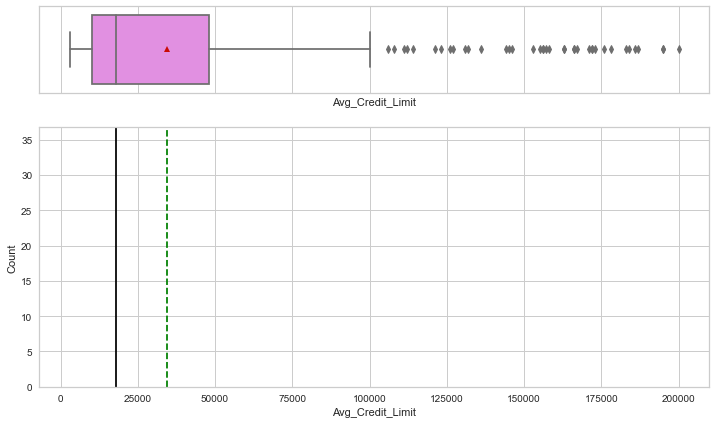

<IPython.core.display.Javascript object>

In [8]:
hist_box(data=df, feature="Avg_Credit_Limit")

Credit Limit is heavily left skewed with a long right tail. Lets take a closer look at the outliers.

In [9]:
# Flagging outliers for the Credit Limit
quartiles = np.quantile(df["Avg_Credit_Limit"], [0.25, 0.75])
Avg_Credit_Limit_4iqr = 4 * (quartiles[1] - quartiles[0])
print(f"Q1 = {quartiles[0]}, Q3 = {quartiles[1]}, 4*IQR = {Avg_Credit_Limit_4iqr}")
outlier_Avg_Credit_Limit = df.loc[
    np.abs(df["Avg_Credit_Limit"] - df["Avg_Credit_Limit"].median())
    > Avg_Credit_Limit_4iqr,
    "Avg_Credit_Limit",
]

print(outlier_Avg_Credit_Limit.value_counts().sort_values(ascending=False))
print(" ")
print(outlier_Avg_Credit_Limit.value_counts().sum())

Q1 = 10000.0, Q3 = 48000.0, 4*IQR = 152000.0
195000    2
172000    2
176000    1
178000    1
200000    1
187000    1
173000    1
184000    1
171000    1
186000    1
183000    1
Name: Avg_Credit_Limit, dtype: int64
 
13


<IPython.core.display.Javascript object>

A quick google search reveals that credit limits of 100k and higher, while indeed possible, are quite rare. They usually have spending minimums and other various restrictions associated with them. Therefore, the numbers present are quite real and are indeed part of the distribution; Because of this, these outliers should not be removed.

Lets see if a log transformation of the data provides better results.

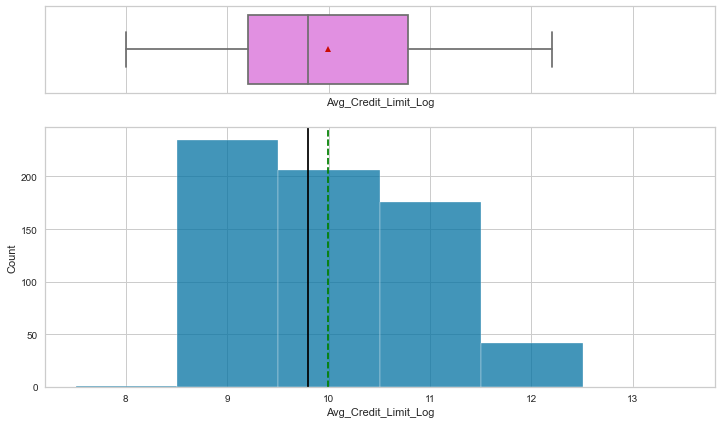

<IPython.core.display.Javascript object>

In [10]:
# Applying log transformation
df["Avg_Credit_Limit_Log"] = np.log(df["Avg_Credit_Limit"])

# Visualizing the transformation
hist_box(data=df, feature="Avg_Credit_Limit_Log")

The log transformation has removed all outliers and created a more normal distribution.

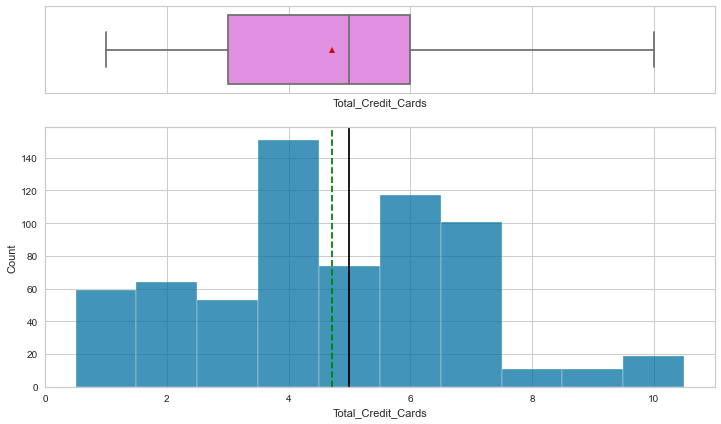

<IPython.core.display.Javascript object>

In [11]:
hist_box(data=df, feature="Total_Credit_Cards")

Range from 0 to 10 with a median of 5. Distribution appears mostly normal.

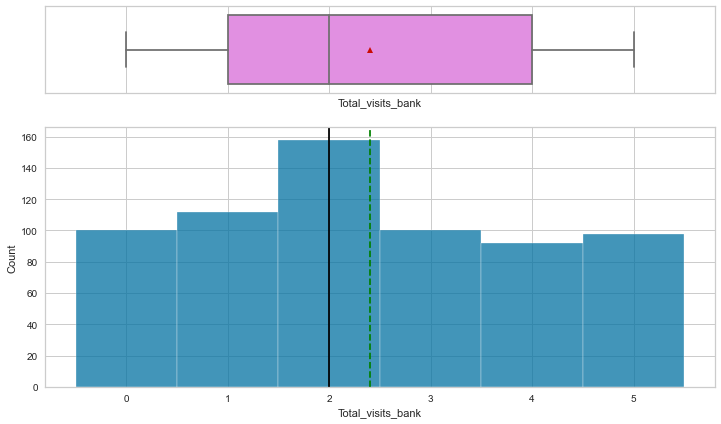

<IPython.core.display.Javascript object>

In [12]:
hist_box(data=df, feature="Total_visits_bank")

Range from 0 to 5 with a median of 2. Distribution is appears normal.

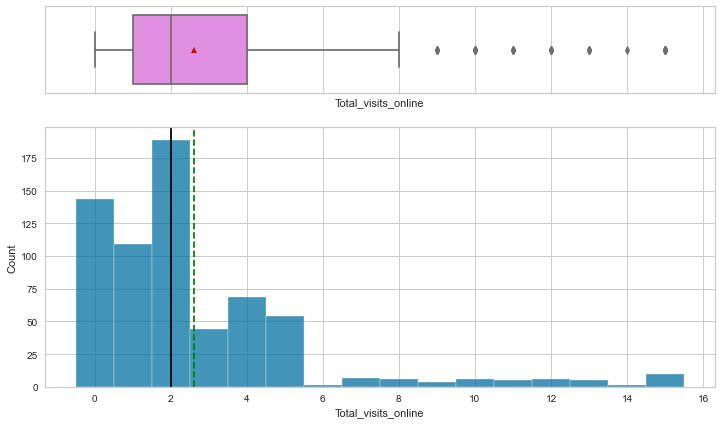

<IPython.core.display.Javascript object>

In [13]:
hist_box(data=df, feature="Total_visits_online")

Range from 0 to 15 with a median of 2. Disregarding outliers, the distribution is normal. Outliers suggests that the bank has section of customers that regularly check their accounts and generally do a significant portion of their banking needs online.

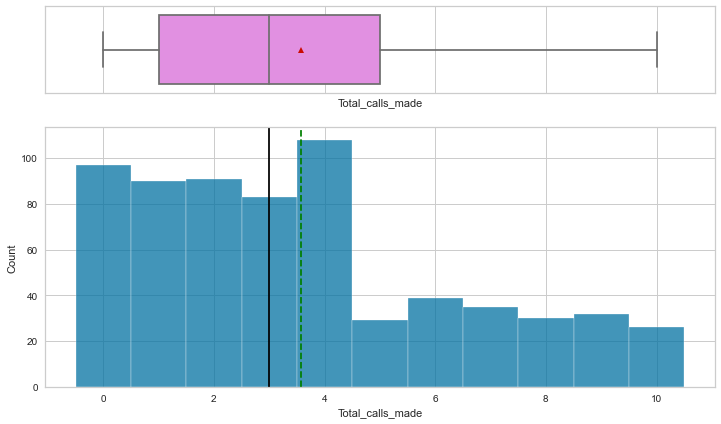

<IPython.core.display.Javascript object>

In [14]:
hist_box(data=df, feature="Total_calls_made")

Range from 0 to 10 with a median of 3. Distribution appears to be uniform with a split between two groups. The first group is 5 calls or less, the second is 5 calls or more. The majority class appears to be 5 calls or less.

**<a id= 'link4'>Data Correlations</a>**

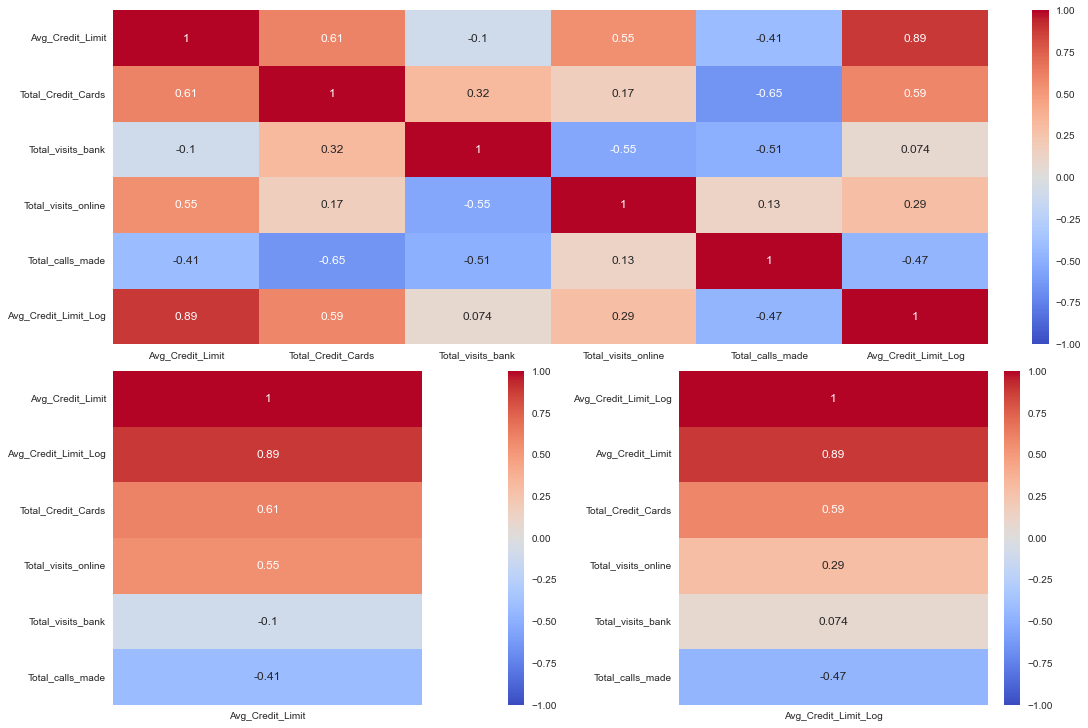

<IPython.core.display.Javascript object>

In [15]:
fig = plt.figure(figsize=(15, 10), constrained_layout=True)
spec = fig.add_gridspec(2, 2)

# Plotting Correlation Heatmap
ax1 = fig.add_subplot(spec[0, :])
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap="coolwarm", ax=ax1)

# Plotting Avg_Credit_Limit correlations
ax2 = fig.add_subplot(spec[1, 0])
Avg_Credit_Limit_corr = sns.heatmap(
    df.corr()[["Avg_Credit_Limit"]].sort_values(by="Avg_Credit_Limit", ascending=False),
    vmin=-1,
    vmax=1,
    annot=True,
    cmap="coolwarm",
    ax=ax2,
)
# Plotting Avg_Credit_Limit_Log correlations
ax3 = fig.add_subplot(spec[1, 1])

x = sns.heatmap(
    df.corr()[["Avg_Credit_Limit_Log"]].sort_values(
        by="Avg_Credit_Limit_Log", ascending=False
    ),
    vmin=-1,
    vmax=1,
    annot=True,
    cmap="coolwarm",
    ax=ax3,
)

**Observations:**
- Log transformation on credit limit does not appear to have significantly impacted the correlations with other variables. Thus, we'll run our model without the transformation.

**Avg_Credit_Limit**
- Positive correlations with total credit cards and online visits.
- Negative correlation with total calls made. This suggests those who make more calls are likely having issues with the bank, and for whatever reason, are being labeled as higher risk thus recieving lower credit limits.
- No correlations with total bank visits. i.e Those who do their banking online are more likely to have higher credit limits

**Total_Credit_Cards**
- Positive correlations with total bank visits and credit limit.
- Significant negative correlation with total calls made. This reinforces the implication that more calls with the bank may indicate a higher financial risk for the bank, although the reason is speculative at best with current information.
- No correlation with total online visits

**Total_Visits_Bank**
- Positive correlation with total credit cards.
- Negative correlation with online visits and total calls. This is what one would expect.
- No correlation with credit limit.

**Total_Visits_Online**
- Positive correlation with credit limit.
- Negative correlation with total bank visits.


**Total_Calls_Made**
- Negative correlation with every variable *except* total online visits.
- Based on personal experience with banking call lines, this implies that (for unkown reasons) these customers are having significant issues with the bank. In this case, this is correlated with reduced interaction with the bank and subsequently a much lower credit limit.

**<a id= 'link5'>Cumulative Data Distributions</a>**

Text(0.5, 1.0, 'Total_Credit_Cards CDF')

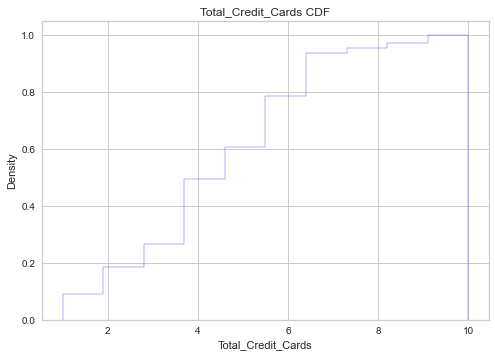

<IPython.core.display.Javascript object>

In [16]:
plt.hist(
    data=df,
    x="Total_Credit_Cards",
    density=True,
    cumulative=True,
    label="CDF",
    histtype="step",
    color="blue",
)
plt.xlabel("Total_Credit_Cards")
plt.ylabel("Density")
plt.title("Total_Credit_Cards CDF", fontsize=12)

- 60% of customers have 5 or less credit cards
- Only 10-5% of customers have 7 credit cards or more

Text(0.5, 1.0, 'Avg_Credit_Limit CDF')

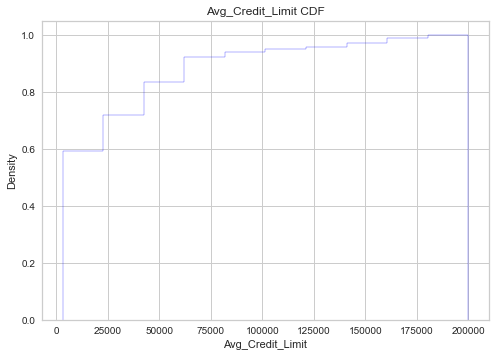

<IPython.core.display.Javascript object>

In [17]:
plt.hist(
    data=df,
    x="Avg_Credit_Limit",
    density=True,
    cumulative=True,
    histtype="step",
    color="blue",
)
plt.xlabel("Avg_Credit_Limit")
plt.ylabel("Density")
plt.title("Avg_Credit_Limit CDF", fontsize=12)

- 90% of customers have a credit limit of 50k or less
- 60% of customers have a credit limit of 25k or less

Text(0.5, 1.0, 'Total_visits_bank CDF')

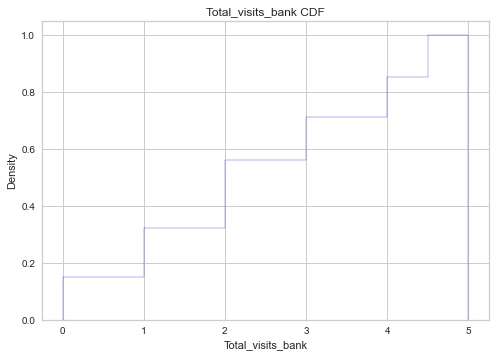

<IPython.core.display.Javascript object>

In [18]:
plt.hist(
    data=df,
    x="Total_visits_bank",
    density=True,
    cumulative=True,
    histtype="step",
    color="blue",
)
plt.xlabel("Total_visits_bank")
plt.ylabel("Density")
plt.title("Total_visits_bank CDF", fontsize=12)

70% of customers have visited the bank 3 times or less

Text(0.5, 1.0, 'Total_calls_made CDF')

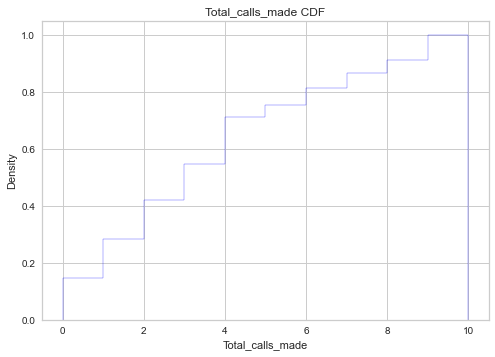

<IPython.core.display.Javascript object>

In [19]:
plt.hist(
    data=df,
    x="Total_calls_made",
    density=True,
    cumulative=True,
    histtype="step",
    color="blue",
)
plt.xlabel("Total_calls_made")
plt.ylabel("Density")
plt.title("Total_calls_made CDF", fontsize=12)

70% of customers have made 4 or less calls

Text(0.5, 1.0, 'Total_visits_online CDF')

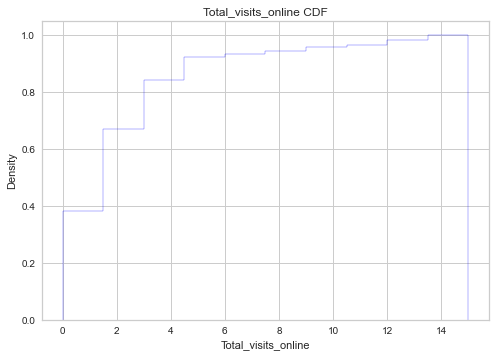

<IPython.core.display.Javascript object>

In [20]:
plt.hist(
    data=df,
    x="Total_visits_online",
    density=True,
    cumulative=True,
    histtype="step",
    color="blue",
)
plt.xlabel("Total_visits_online")
plt.ylabel("Density")
plt.title("Total_visits_online CDF", fontsize=12)

80% of customers have visited the bank online 4 times or less

### <a id= 'link6'>EDA & Data Cleaning Summary</a>

- Data was recieved already cleaned with no missing values. A log transformation was performed on credit limit but this did not appear to have any effect on correlations within the data set.
- All distributions of data appear normal. Only credit limit has significant skew and outliers.
- Overall, the data is behaving as per initial expectations.

**<a id= 'link7'>Key Insights</a>**
- 70% of customers have made 4 or less calls
- 70% of customers have visited the bank 3 times or less
- 90% of customers have a credit limit of 50k or less
    - 60% of customers have a credit limit of 25k or less
- 60% of customers have 5 or less credit cards
- Total calls made has a significant negative correlation with all variables. Refer to data correlations section for more in depth insights.
- All other correlations appear as expected

### <a id= 'link8'>Data Preprocessing</a>

In [21]:
# Removing log transformed column
df.drop("Avg_Credit_Limit_Log", axis=1, inplace=True)

# Scaling the each data set before clustering
scaler = StandardScaler()
subset = df.copy()
subset_scaled = scaler.fit_transform(subset)

# Creating a dataframe from the scaled data
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

<IPython.core.display.Javascript object>

### <a id= 'link9'>K-Means Clustering</a>

**<a id= 'link10'>Finding the Optimal K-Value</a>**

Number of Clusters: 1 	Average Distortion: 2.0069222262503614
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.990772333470802
Number of Clusters: 6 	Average Distortion: 0.9430843103448057
Number of Clusters: 7 	Average Distortion: 0.9094290022428964
Number of Clusters: 8 	Average Distortion: 0.8891380888508975


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

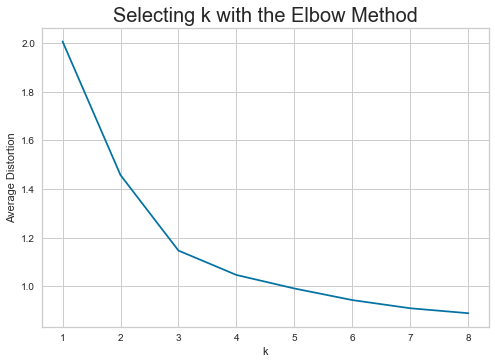

<IPython.core.display.Javascript object>

In [22]:
# Checking K values 1-9 for scaled data
clusters = range(1, 9)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)

Elbow appears to be at either 3 or 4 clusters. Lets check the silhouette score.

For n_clusters = 2, silhouette score is 0.41842496663215445
For n_clusters = 3, silhouette score is 0.5157182558881063
For n_clusters = 4, silhouette score is 0.3556670619372605
For n_clusters = 5, silhouette score is 0.2717470361089752
For n_clusters = 6, silhouette score is 0.25601504934639663
For n_clusters = 7, silhouette score is 0.2484780407682755
For n_clusters = 8, silhouette score is 0.2261268477139729
For n_clusters = 9, silhouette score is 0.21993804286643806


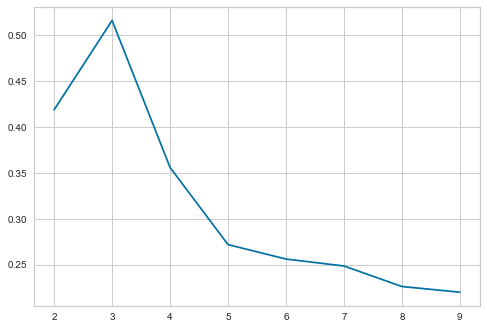

<IPython.core.display.Javascript object>

In [23]:
# Checking silhouette scores for scaled data
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

A value of 3 for k has the highest silhouette score with a steep drop off immediately after. We'll perform one last check on the silhouette scores before determining the optimal k value.

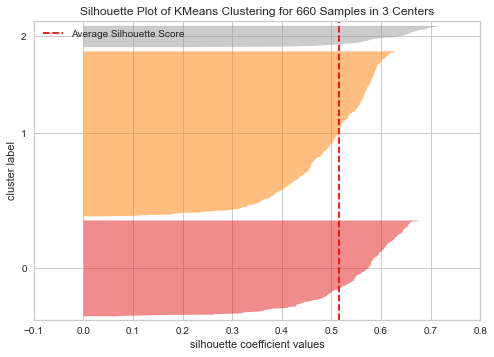

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [24]:
# Checking the silhouette coefficients with k-value at 3
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

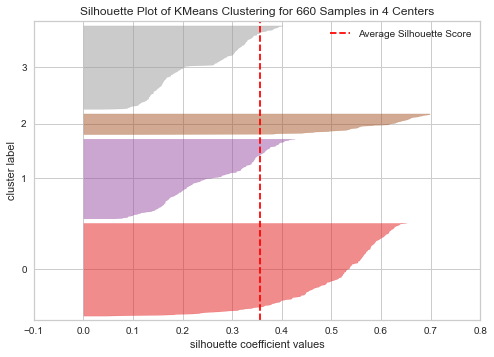

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [25]:
# Checking the silhouette coefficients with k-value at 4
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

Visualizing the silhouette scores has confirmed that 3 is the optimal value for k.

In [26]:
# Creating 3 clusters
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=3, random_state=1)

<IPython.core.display.Javascript object>

**<a id= 'link11'>K-Means Cluster Profiling</a>**

In [27]:
# Adding kmeans cluster labels to the original and scaled dataframes
df["K_means_segments"] = kmeans.labels_
subset_scaled_df["K_means_segments"] = kmeans.labels_

# Finding mean value for each variable in each cluster
cluster_profile = df.groupby("K_means_segments").mean()

# Creating column with total sample counts in each cluster
cluster_profile["Count_in_each_segments"] = (
    df.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

# Displaying cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Count_in_each_segments
K_means_segments,,,,,,
0,12174.107143,2.410714,0.933036,3.553571,6.870536,224
1,33782.383420,5.515544,3.489637,0.981865,2.000000,386
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


<IPython.core.display.Javascript object>

Observations:
- Each cluster increases in credit limit, as well as total credit cards
- Total calls made decreases with each cluster
- The second cluster has the highest average bank visits at 3.48
- The first cluster has the highest total calls made at 6.87
- The first and second cluster are quite large making up 92% of the total
    - The third cluster makes up the remaining 8% with only 50 observations

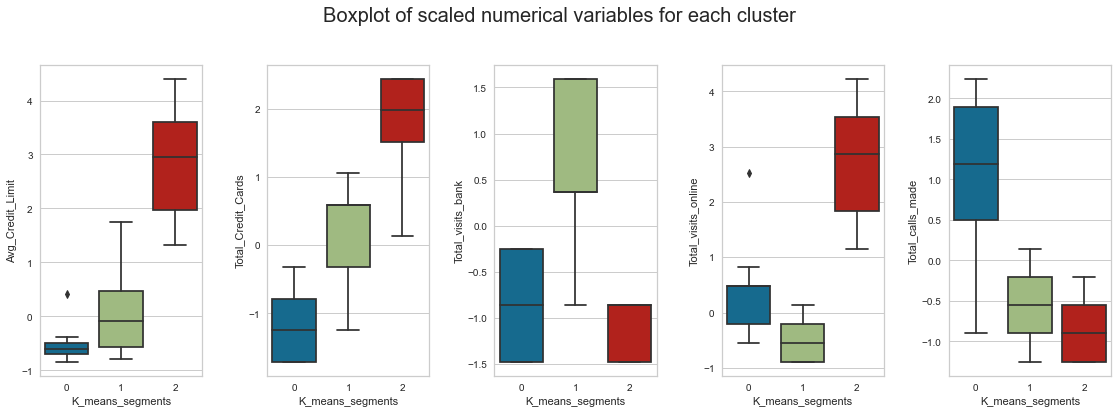

<IPython.core.display.Javascript object>

In [28]:
# Visualizing scaled numerical variables for each cluster
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=subset_scaled_df[num_col[counter]],
        x=subset_scaled_df["K_means_segments"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

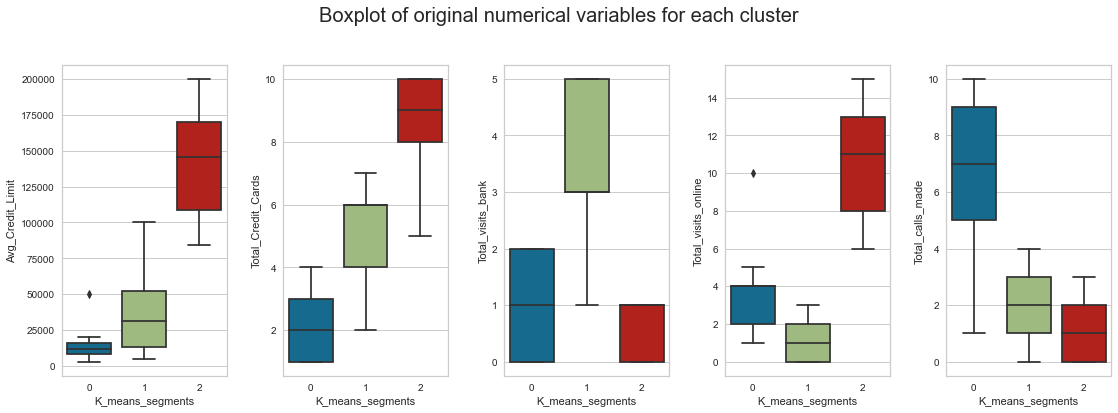

<IPython.core.display.Javascript object>

In [29]:
# Visualizing boxplot of original numerical values for each cluster
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df[num_col[counter]], x=df["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

<AxesSubplot:xlabel='K_means_segments'>

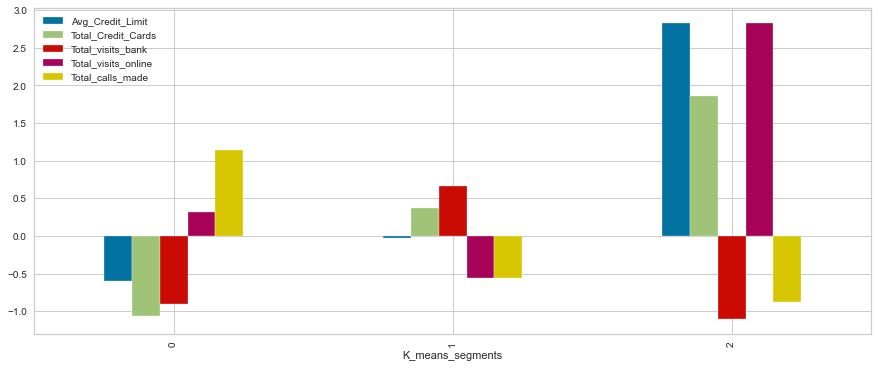

<IPython.core.display.Javascript object>

In [30]:
# Visualizing means of each clusters variables in the scaled data set
subset_scaled_df.groupby("K_means_segments").mean().plot.bar(figsize=(15, 6))

#### <a id= 'link12'>Key Insights</a>

**Cluster 0:**
- Credit Limit is an average of 12k, with one outlier at 50k
- Number of credit cards is around 2, and does not exceed 4
- Number of visits to the bank is quite low with an average of one per year
- Online visits is higher at 2-4 per year
- Total calls made per year is significantly higher and has the greatest range (1-10) with an average of 7
- Despite the large number of observations within this cluster, the range of results is incredibly concentrated in comparison to to other clusters.

This group appears to carry the greatest amount of *implied* risk to the bank as well as having the most issues. Customers in this group appear to perfer calling the bank rather than interacting online or in-person. All of this contributes to an average credit score that is in the bottom 1/3 of all customers.

**Cluster 1:**
- All variables are, on average, very close to nominal. i.e. They only vary by half of one standard deviation from the mean in any given metric
- Credit limit is around 33k
- Number of credit cards is 5
- These customers visit the bank the most out of any given group averaging at least 3 visits a year.
    - This translates to less online visits, and less calls per year (only 1 or 2 per year)
    
This group seems to represent the average customer for this bank. With 386 total observations this group makes up nearly 60% of the total data set. All metrics are near the scaled mean with little deviation. They only notable difference is their preferance to visit the bank inperson.

**Cluster 2:**
- This is the smallest group with only 50 observations. i.e only 8% of the total.
- Credit limit is extremely high, and is well within the top 1% of all customers
- The total number of credit cards is also incredibley high, with an average of 9
- In-person visiss to the bank do not exceed 1 on average, most do not visit the bank at all
- Conversely, online banking is the highest in this cluster, again well within the top 1% of all customers
- Calls made to the bank is very low as well.

This final cluster seems to be the financial elite for the bank. They have the highest credit limit and the most credit cards. Interestingly, this group almost exclusively interacts with the bank online and only appears to visit or call when absolutely necessary.

### <a id= 'link13'>Hierarchical Clustering</a>

**<a id= 'link14'>Determining Optimal Distance Metric and Linkage Method</a>**

In [31]:
# List of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# List of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

# Printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "\nHighest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Cophenetic correlation for Euclidean distance and single linkage is 0.8981791108157512.
Cophenetic correlation for Euclidean distance and complete linkage is 0.884420725860894.
Cophenetic correlation for Euclidean distance and average linkage is 0.9102691112621796.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.9069999252384202.
Cophenetic correlation for Chebyshev distance and single linkage is 0.8142004375043415.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8565360723350399.
Cophenetic correlation for Chebyshev distance and average linkage is 0.9092248615295281.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.9046661477870559.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.8650806042953467.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.6100510675083306.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8419295288198604.
Cophenetic cor

<IPython.core.display.Javascript object>

The best distance metric is Euclidean with an average linkage. However, there are some more specific linkage methods within the Euclidean distance metric. Let's investigate those as well before moving forward.

In [32]:
# List of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

# Printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "\nHighest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Cophenetic correlation for single linkage is 0.8981791108157512.
Cophenetic correlation for complete linkage is 0.884420725860894.
Cophenetic correlation for average linkage is 0.9102691112621796.
Cophenetic correlation for centroid linkage is 0.906845257340526.
Cophenetic correlation for ward linkage is 0.7566252666432097.
Cophenetic correlation for weighted linkage is 0.9069999252384202.

Highest cophenetic correlation is 0.9102691112621796, which is obtained with average linkage.


<IPython.core.display.Javascript object>

The previously observed best cophenetic correlation is still the optimal choice. Other methods that achieved similar results were:
- Chebyshev with either average or weighted linkage
- Cityblock ("Manhattan") with average linkage

**<a id= 'link15'>Finding Optimal Number of Clusters with Dendograms</a>**

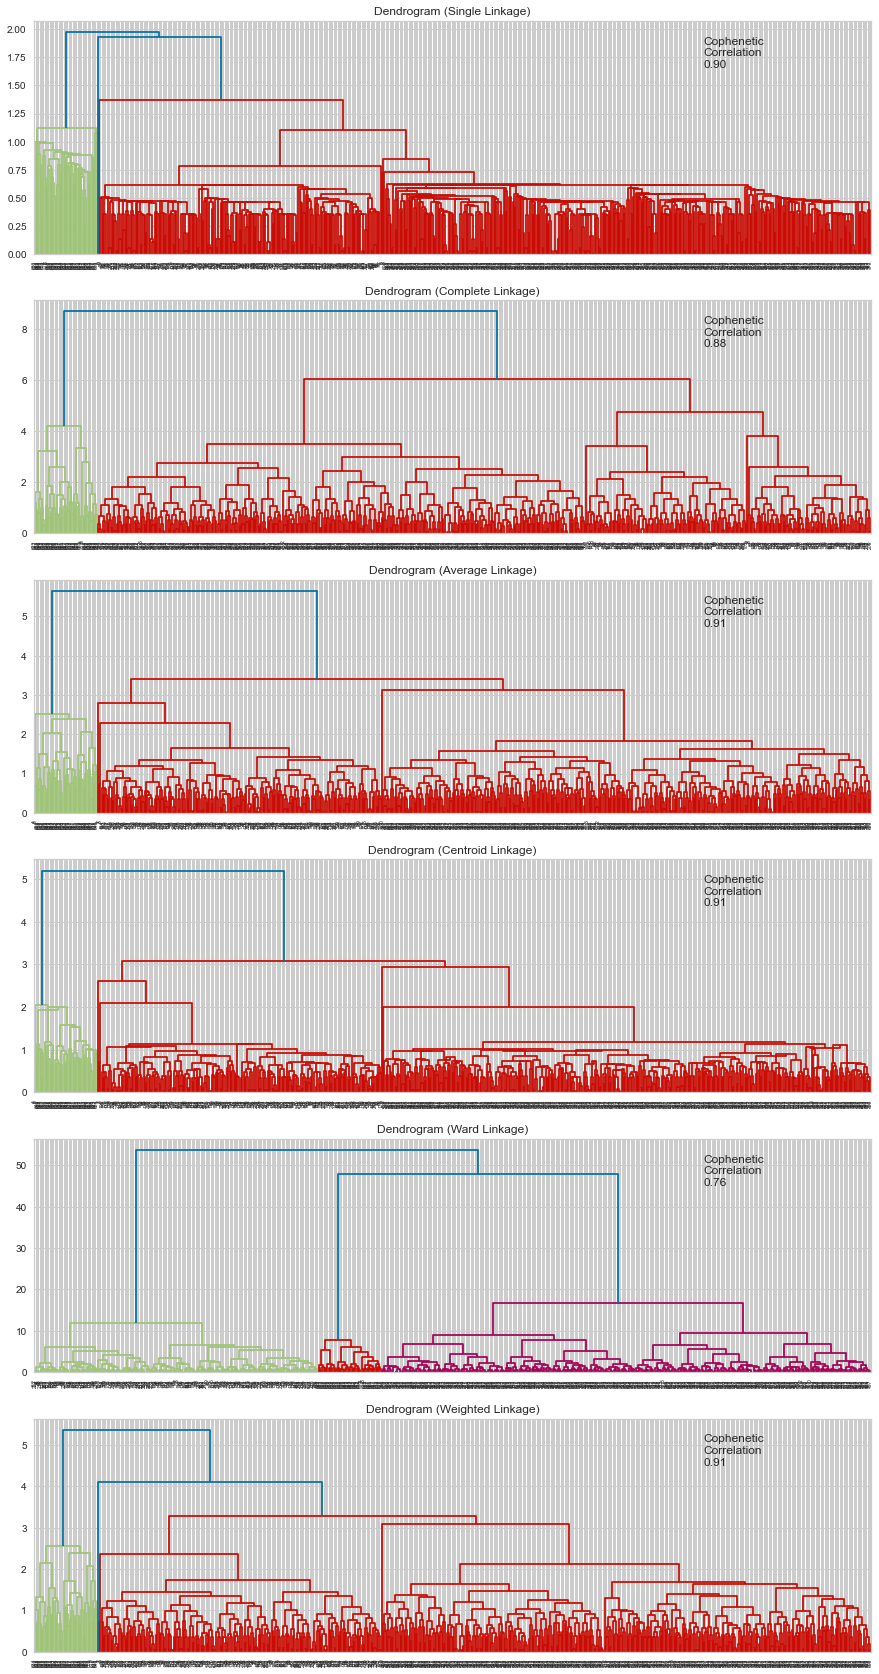

<IPython.core.display.Javascript object>

In [33]:
# List of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# Lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# Creating a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# Enumerating through the list of linkage methods above
# For each linkage method, we'll plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append([method, coph_corr])

All dendograms for each linkage method appear a good job at creating distinct and seperate clusters. The ward linkage, however is the most distinict out of the available options, and therefore should be the easiest to interpret.

In [34]:
# Comparing Cophenetic Coefficients for all dendograms
df_cc = pd.DataFrame(compare, columns=compare_cols)
df_cc

,Linkage,Cophenetic Coefficient
0,single,0.898
1,complete,0.884
2,average,0.910
3,centroid,0.907
4,ward,0.757
5,weighted,0.907


<IPython.core.display.Javascript object>

Before making a final decision on the number of clusters, lets take a look at the dendograms for chebyshev and cityblock with average and weighted linkage methods. (Their cophenetic coefficients were very similar)

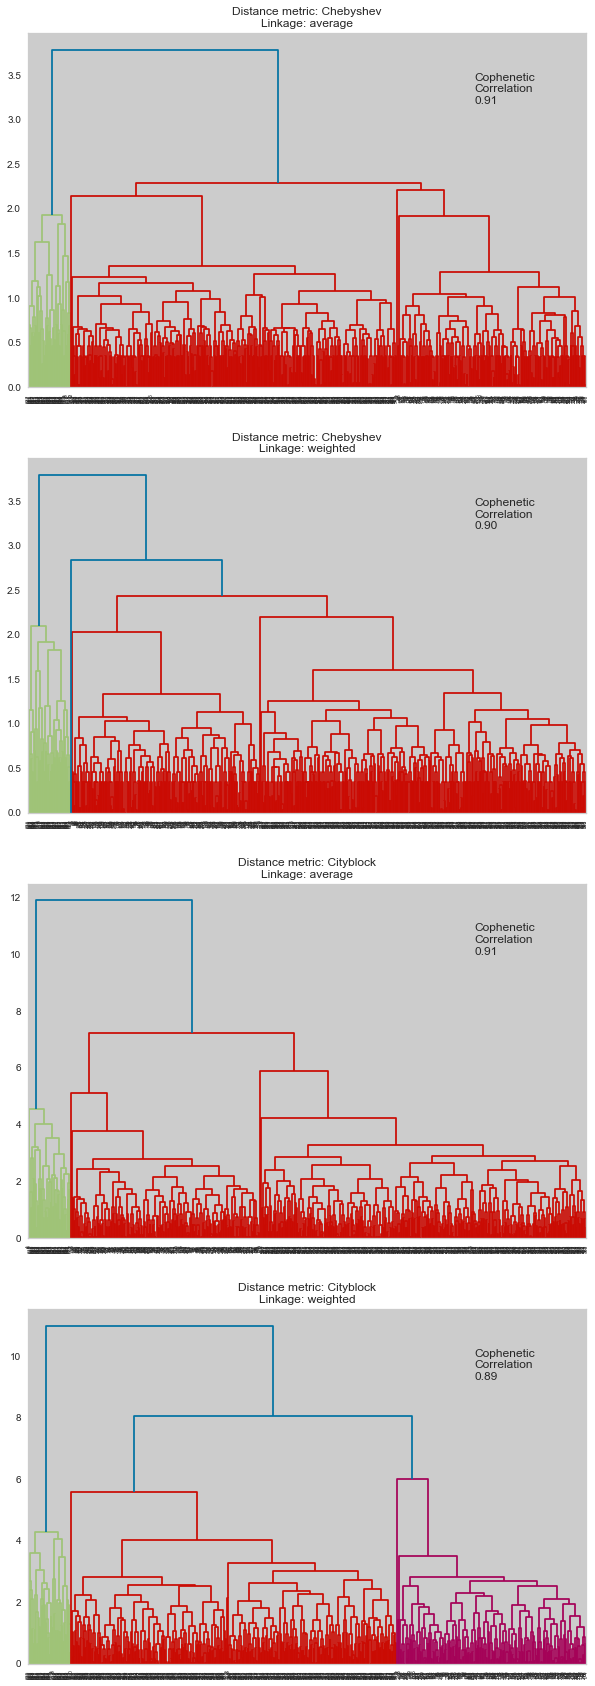

<IPython.core.display.Javascript object>

In [35]:
# List of distance metrics
distance_metrics = ["chebyshev", "cityblock"]

# List of linkage methods
linkage_methods = ["average", "weighted"]

# Creating a subplot image
fig, axs = plt.subplots(
    len(distance_metrics) + len(distance_metrics), 1, figsize=(10, 30)
)

i = 0
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)

        dendrogram(Z, ax=axs[i])
        axs[i].set_title("Distance metric: {}\nLinkage: {}".format(dm.capitalize(), lm))

        coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
        axs[i].annotate(
            f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
            (0.80, 0.80),
            xycoords="axes fraction",
        )
        i += 1

Cityblock with average linkage is giving the clearest seperation between clusters along with a higher cophenteic correlation than Euclidian with ward linkage. Additionally, both possible dendograms show a clear grouping of three seperate clusters. Thus, we'll create a hierarchical clustering model with 3 clusters using the cityblock distance method and average linkage.

### <a id= 'link16'>Comparing K-Means & Hierarchical Clustering Methods</a>

In [36]:
# Fitting the model
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="cityblock", linkage="average")
HCmodel.fit(subset_scaled_df)

AgglomerativeClustering(affinity='cityblock', linkage='average', n_clusters=3)

<IPython.core.display.Javascript object>

In [37]:
# Adding hierarchical cluster labels to the original and scaled dataframes
subset_scaled_df["HC_Clusters"] = HCmodel.labels_
df["HC_Clusters"] = HCmodel.labels_

<IPython.core.display.Javascript object>

In [38]:
# Creating hierarchical cluster data frame
HC_cluster_profile = df.groupby("HC_Clusters").mean()
HC_cluster_profile.drop("K_means_segments", axis=1, inplace=True)
HC_cluster_profile["Count_in_each_segments"] = (
    df.groupby("HC_Clusters")["Avg_Credit_Limit"].count().values
)

# Let's display cluster profiles
HC_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Count_in_each_segments
HC_Clusters,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,141040.000000,8.740000,0.600000,10.900000,1.080000,50
2,12174.107143,2.410714,0.933036,3.553571,6.870536,224


<IPython.core.display.Javascript object>

This appears to be the same result as k-means clustering. Lets view it one more time to compare.

In [39]:
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Count_in_each_segments
K_means_segments,,,,,,
0,12174.107143,2.410714,0.933036,3.553571,6.870536,224
1,33782.383420,5.515544,3.489637,0.981865,2.000000,386
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


<IPython.core.display.Javascript object>

Heirarchical clustering has given us the same results as k-means clustering. The only difference is in the order of each cluster. Because previous analysis was already done with the k-means cluster order, we'll use that as the basis for our business reccomendations.

### <a id= 'link17'>Business Recomendations</a>

**Cluster 0:** 
- Out of the 660 customers overall, customers in cluster 0 make up 33.9% of the total.
- This cluster consists of customers who are extremely active over the phone, moderately active via online banking, but appear averse to interactions in person.
- The credit limit of this group is well below the average and is in the bottom third percentile.

The bank may want to consider addressing the potential issues present in this group by determing the reason for increased phone activity. The below average credit limit implies either a greater financial risk present in this group, or a general reluctance to engage with the banks current financial options. This group may need extra incentives such as reward programs to encourage engagment within the current banking ecosystem.

**Cluster 1**
- Out of the 660 customers overall, customers in cluster 1 make up 58.4% of the total.
- Their metrics are all nominal, with a slight preferance towards visting the bank in person. Online interaction is less than once a year on average.

Customers in cluster 1 appear to financially stable and less prone to financial risk, as indicated by their higher average credit limit. The preference towards in person banking indicates that the bank should continue to make this option available as almost 60% of customers are within this cluster. Since this group is only distinct in that their metrics are all nominal, a General marketing campaigns can be targeted to this group.

**Cluster 2**
- This is the smallest group making up only 8% of the total
- Cluster 2 has the highest credit limit along with the most total credit cards
- There is a significant preferance for online banking

Customers in cluster 2, while a small minority of the total customer base, appear to hold a significant portion of the financial power. When interacting with the bank this group vastly perfers online banking methods with an average of 11 online interactions per year and less than 0 in-person. The bank should focus marketing campaigns for this group to be exclusively online. Additionally, as evidenced by the extremely high credit limit, luxury and premium products (such as better loans, interest rates, investment options, etc.) campaigns could be focused to this group.